In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
def rmse(y_act,y_pred):
    rms=sqrt(mean_squared_error(y_act,y_pred))
    return rms

In [3]:
X_train = pd.read_csv('Data/train_data_hhp.csv')
X_test = pd.read_csv('Data/test_data_hhp.csv')

X_train, X_validation = train_test_split(X_train, test_size=0.3, random_state=0)

year_2_data = pd.read_csv('Data/train_data_hhp.csv')
year_2_data.drop(['DaysInHospital','Year','ClaimsTruncated','MemberID'], axis=1, inplace=True)

Y_train = X_train['DaysInHospital']
Y_test = X_test['DaysInHospital']
Y_validation = X_validation['DaysInHospital']

X_train.drop(['DaysInHospital','Year','ClaimsTruncated','MemberID'], axis=1, inplace=True)
X_test.drop(['DaysInHospital','Year','ClaimsTruncated','MemberID'], axis=1, inplace=True)
X_validation.drop(['DaysInHospital','Year','ClaimsTruncated','MemberID'], axis=1, inplace=True)

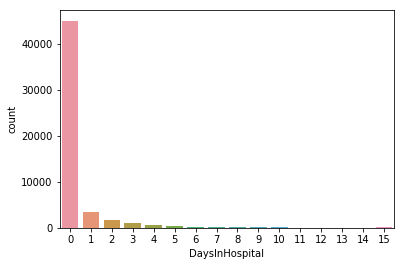

In [4]:
import seaborn as sns
sns.countplot(Y_train)

### Convert output by log scale


In [5]:
logYtrain=np.log(Y_train+1)
logYtest=np.log(Y_test+1)
logYvalidation=np.log(Yvalidation+1)

In [6]:
XGregr = XGBRegressor()

In [7]:
XGregr.fit(X_train, logYtrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [8]:
logY_pred_test = XGregr .predict(X_test)
logY_pred_train = XGregr .predict(X_train)
logY_pred_validation = XGregr .predict(X_validation)

#truncated output
logY_pred_test[logY_pred_test < 0]=0
logY_pred_train[logY_pred_train < 0]=0
logY_pred_validation[logY_pred_validation < 0]=0

print('error on training set: ', rmse(logYtrain, logY_pred_train),
     'error on validation set: ', rmse(logYvalidation, logY_pred_validation),
  #   )#,
      'error on testing set: ', rmse(logYtest, logY_pred_test)
    )

error on training set:  0.45011941164603225 error on validation set:  0.4635478740921028 error on testing set:  0.4483921996518416


## Feature selection

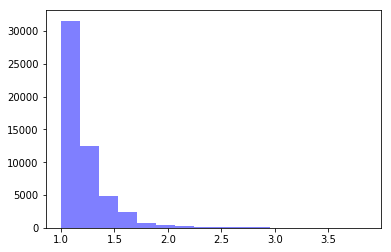

In [9]:
num_bins=16
n, bins, patches = plt.hist(np.exp(logY_pred_train), num_bins, facecolor='blue', alpha=0.5)
plt.show()

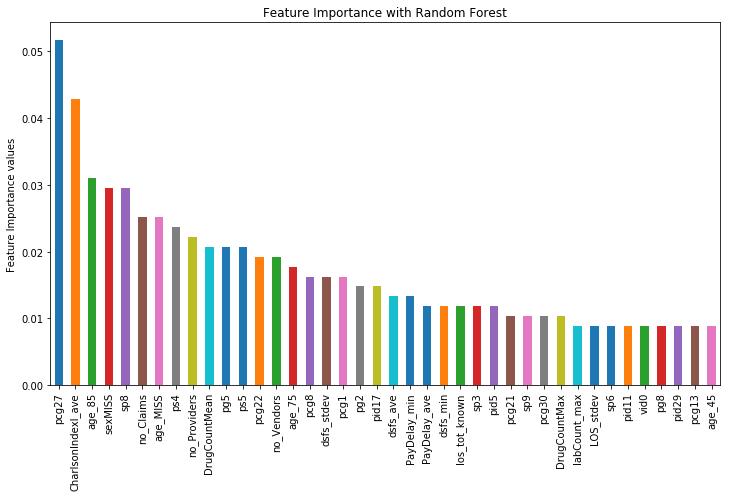

In [10]:
# Plot the top 40 important features
imp_feat_rf = pd.Series(XGregr.feature_importances_, index=X_train.columns).sort_values(ascending=False)
imp_feat_rf[:40].plot(kind='bar', title='Feature Importance with Random Forest', figsize=(12,8))
plt.ylabel('Feature Importance values')
plt.subplots_adjust(bottom=0.25)
plt.savefig('FeatImportance.png')
plt.show()

### Remove features with high correlation with no_Claims

In [11]:
list0=['no_Providers', 'no_Vendors', 'no_PCPs', 'no_PlaceSvcs','no_Claims',
       'no_Specialities', 'no_PrimaryConditionGroups', 'no_ProcedureGroups']

del list0[2]
list0

['no_Providers',
 'no_Vendors',
 'no_PlaceSvcs',
 'no_Claims',
 'no_Specialities',
 'no_PrimaryConditionGroups',
 'no_ProcedureGroups']

In [12]:
X_train.drop(list0,axis=1, inplace=True)
X_validation.drop(list0,axis=1, inplace=True)
X_test.drop(list0,axis=1, inplace=True)
year_2_data.drop(list0,axis=1, inplace=True)

In [13]:
XGregr.fit(X_train,logYtrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [14]:
logY_pred_test = XGregr .predict(X_test)
logY_pred_train = XGregr .predict(X_train)
logY_pred_validation = XGregr .predict(X_validation)

#truncated output
logY_pred_test[logY_pred_test < 0]=0
logY_pred_train[logY_pred_train < 0]=0
logY_pred_validation[logY_pred_validation < 0]=0

print('error on training set: ', rmse(logYtrain, logY_pred_train),
     'error on validation set: ', rmse(logYvalidation, logY_pred_validation),
  #   )#,
      'error on testing set: ', rmse(logYtest, logY_pred_test)
    )

error on training set:  0.45051341699539793 error on validation set:  0.4635411982991441 error on testing set:  0.44834107113172655


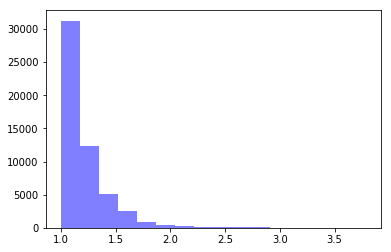

In [15]:
num_bins=16
n, bins, patches = plt.hist(np.exp(logY_pred_train), num_bins, facecolor='blue', alpha=0.5)
plt.show()

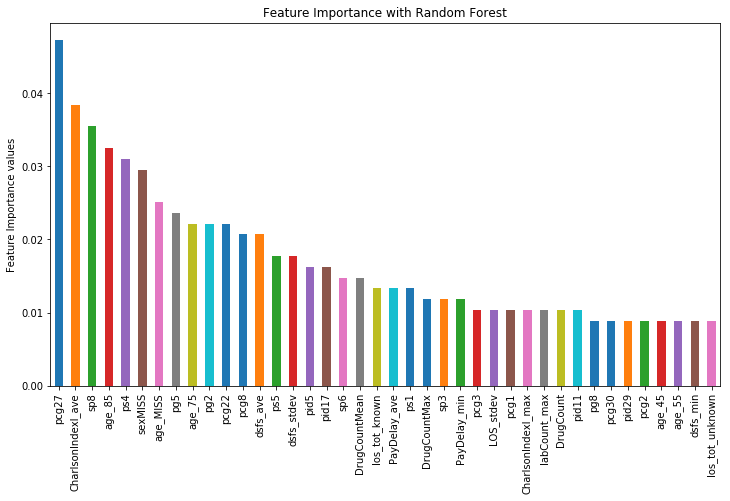

In [16]:
# Plot the top 40 important features
imp_feat_rf = pd.Series(XGregr.feature_importances_, index=X_train.columns).sort_values(ascending=False)
imp_feat_rf[:40].plot(kind='bar', title='Feature Importance with Random Forest', figsize=(12,8))
plt.ylabel('Feature Importance values')
plt.subplots_adjust(bottom=0.25)
plt.savefig('FeatImportance.png')
plt.show()

### remove all features with 0 important value



In [17]:
#remove all features with 0 important value
list1=list()
for indx, val in imp_feat_rf.iteritems():
    if val==0:
        list1.append(indx)
pd.DataFrame(list1).to_csv("Data/RmvSet1_XGBregr.csv", encoding='utf-8')

In [18]:
X_train.drop(list1,axis=1, inplace=True)
X_validation.drop(list1,axis=1, inplace=True)
X_test.drop(list1,axis=1, inplace=True)
year_2_data.drop(list1,axis=1, inplace=True)

In [19]:
XGregr.fit(X_train,logYtrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [20]:
logY_pred_test = XGregr .predict(X_test)
logY_pred_train = XGregr .predict(X_train)
logY_pred_validation = XGregr .predict(Xvalidation)

#truncated output
logY_pred_test[logY_pred_test < 0]=0
logY_pred_train[logY_pred_train < 0]=0
logY_pred_validation[logY_pred_validation < 0]=0

print('error on training set: ', rmse(logYtrain, logY_pred_train),
     'error on validation set: ', rmse(logYvalidation, logY_pred_validation),
  #   )#,
      'error on testing set: ', rmse(logYtest, logY_pred_test)
    )

error on training set:  0.45051341699539793 error on validation set:  0.4635411982991441 error on testing set:  0.44834107113172655


### Export predict output

In [28]:
logY2_pred=XGregr.predict(year_2_data)
logY2_pred[logY2_pred < 0]=0

Y2_pred=np.exp(logY2_pred)-1
Y3_pred=np.exp(logY_pred_test)-1

Y2_pred= pd.DataFrame(Y2_pred, columns=['Y_pred_XGBregr_notScaled'])
Y3_pred= pd.DataFrame(Y3_pred, columns=['Y_pred_XGBregr_notScaled'])

pd.DataFrame(Y2_pred).to_csv("Data/Y2_pred_XGBregr_notScaled.csv", encoding='utf-8')
pd.DataFrame(Y3_pred).to_csv("Data/Y3_pred_XGBregr_notScaled.csv", encoding='utf-8')

## Tuning

In [22]:
XGregr = XGBRegressor(n_estimators=500)

In [23]:
XGregr.fit(X_train,logYtrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [24]:
logY_pred_test = XGregr .predict(Xtest)
logY_pred_train = XGregr .predict(X_train)
logY_pred_validation = XGregr .predict(X_validation)

#truncated output
logY_pred_test[logY_pred_test < 0]=0
logY_pred_train[logY_pred_train < 0]=0
logY_pred_validation[logY_pred_validation < 0]=0

print('error on training set: ', rmse(logYtrain, logY_pred_train),
     'error on validation set: ', rmse(logYvalidation, logY_pred_validation),
  #   )#,
      'error on testing set: ', rmse(logYtest, logY_pred_test)
    )

error on training set:  0.4321849918041614 error on validation set:  0.4642442533067501 error on testing set:  0.4523263137900572


## Tuning

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

In [26]:
def rmsle(logY_pred,logY_act):
    rms=sqrt(mean_squared_error(logY_pred, logY_act))
    return rms

my_scorer = make_scorer(rmsle, greater_is_better=False)

In [27]:
from timeit import default_timer as timer

hyper_space_XGB = {'n_estimators': list(range(100, 1000)),
                   'boosting_type': ['gbdt', 'dart', 'goss'],
                   'max_depth':  list(range(2, 25)),
                   'num_leaves': list(range(30, 250)),
                   'subsample': list(np.linspace(0.3, 0.9, 30)),
                   'colsample_bytree': list(np.linspace(0.3, 0.9, 30)),
                   'learning_rate': np.logspace(np.log(0.003), np.log(0.1), base=np.exp(1), num=50),
                   'reg_alpha': list(np.linspace(0, 1)),
                   'reg_lambda': list(np.linspace(0, 1)),
                   'min_child_samples': list(range(20, 500, 5)),
                   'min_child_weight': list(np.linspace(0.0005, 0.005))
              }
start = timer()
est = XGBRegressor(n_jobs=-1, random_state=42, verbose=1, objective='reg:linear')
rs = RandomizedSearchCV(est, hyper_space_XGB, scoring=my_scorer, n_iter=50, cv=3, verbose=1, random_state=42)  # 
rs_results = rs.fit(X_train_scaled, Y_train)
print("BEST PARAMETERS: " + str(rs_results.best_params_))
print("BEST CV SCORE: " + str(1 - rs_results.best_score_))
end = timer()
# Predict (after fitting RandomizedSearchCV is an estimator with best parameters)
Y_pred_validation = rs.predict(X_validation_scaled)
#y_pred_new = 10**y_pred - 1
#y_test_new = 10**y_test - 1

# Score
score = rmsle(Y_pred_validation, Y_validation)
print("RMSLE SCORE ON VALIDATION DATA: {}".format(score))
print("ELAPSED TIME: " + str((end-start) / 60))

NameError: name 'X_train_scaled' is not defined